In [ ]:
#| default_exp glssm

# use x86 for testing purposes
import jax.config as config
from jaxtyping import Float, Array
import matplotlib.pyplot as plt
from isssm.kalman import kalman, smoother
import fastcore.test as fct

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
#| hide
# use x86 for testing purposes
config.update("jax_enable_x64", True)

# Gaussian Linear State Space Models
> Simulation and components

Consider a gaussian state space model of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t) & t=0, \dots, n.
\end{align*}
$$
As the joint distribution of $(X_0, \dots, X_n, Y_0, \dots, Y_n)$ is gaussian, we call it a **G**aussian **l**inear  **s**tate **s**pace **m**odel (GLSSM).

## Sampling from the joint distribution
To obtain a sample $(X_0, \dots, X_n), (Y_0, \dots, Y_n)$ we first simulate from the joint distribution of the states and then, as observations are coniditionally independent of one another given the states, simulate all states at once.

In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from jaxtyping import Float, Array
from jax.lax import scan
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

In [ ]:
# | export

vmatmul = vmap(jnp.matmul, (None, 0))


def simulate_states(
    x0: Float[Array, "m"],
    A: Float[Array, "n m m"],
    Sigma: Float[Array, "n+1 m m"],
    N: int,
    key: jrn.KeyArray,
) -> Float[Array, "N n+1 m"]: 
    """Simulate states of a GLSSM

    Parameters
    ----------
    x0 : 
        initial mean $\\mathbf E \\left( X_0 \\right)$
    A : 
        transition matrices $A_t$, $t = 0, \\dots, n-1$
    Sigma : 
        covariance matrices of innovations $\\Sigma_t$, $t = 0, \\dots, n$
    N : 
        number of samples to draw
    key : jrn.KeyArray
        the random state

    Returns
    -------
    X
        an array of N samples from the state distribution 
    """

    def sim_next_states(carry, inputs):
        x_prev, key = carry
        A, Sigma = inputs

        next_loc = vmatmul(A, x_prev)
        key, subkey = jrn.split(key)

        samples = MVN(next_loc, Sigma).sample(seed=subkey)

        return (samples, key), samples

    (m,) = x0.shape
    A_ext = jnp.concatenate((jnp.eye(m)[jnp.newaxis], A))

    x0_recast = jnp.broadcast_to(x0, (N, m))
    key, subkey = jrn.split(key)
    _, X = scan(sim_next_states, (x0_recast, subkey), (A_ext, Sigma))

    return X.transpose((1, 0, 2))

In [ ]:
#| export

def simulate_glssm(
    x0: Float[Array, "m"],
    A: Float[Array, "n m m"],
    B: Float[Array, "n+1 p m"],
    Sigma: Float[Array, "n+1 m m"],
    Omega: Float[Array, "n+1 p p"],
    N: int,
    key: jrn.KeyArray,
) -> (Float[Array, "N n+1 m"], Float[Array, "N n+1 p"]):
    r"""Simulate states and observations of a GLSSM

    Parameters
    ----------
    x0 : 
        initial mean $\mathbf E X_0$
    A : 
        transition matrices $A_t$, $t = 0, \dots, n - 1$
    B : 
        observation matrices $B_t$, $t = 0, \dots, n$
    Sigma : 
        covariance matrices of innovations $\Sigma_t$, $t = 0, \dots, n$
    Omega : 
        covariance matrices of errors $\Omega_t$, $t=0, \dots, n$
    N : int
        number of sample paths
    key : jrn.KeyArray
        the random state

    Returns
    -------
    X, Y : 
        a tuple of two arrays each with of N samples from the state/observation distribution
    """
    key, subkey = jrn.split(key)
    X = simulate_states(x0, A, Sigma, N, subkey).transpose((1, 0, 2))

    S = vmap(vmatmul, (0, 0))(B, X)

    # samples x time x space
    X = X.transpose((1, 0, 2))

    S = S.transpose((1, 0, 2))

    key, subkey = jrn.split(key)
    Y = MVN(S, Omega).sample(seed=subkey)

    return X, Y

In [ ]:
m, p, n = 3, 2, 100
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2, omega2 = 1, 1
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
Omega = jnp.broadcast_to(omega2 * jnp.eye(p), (n + 1, p, p))
x0 = jnp.zeros(m)

key = jrn.PRNGKey(53412312)
key, subkey = jrn.split(key)
(X, ), (Y,) = simulate_glssm(x0, A, B, Sigma, Omega, 1, subkey)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| hide
fct.test_eq(X.shape, (n+1,m))
fct.test_eq(Y.shape, (n+1,p))

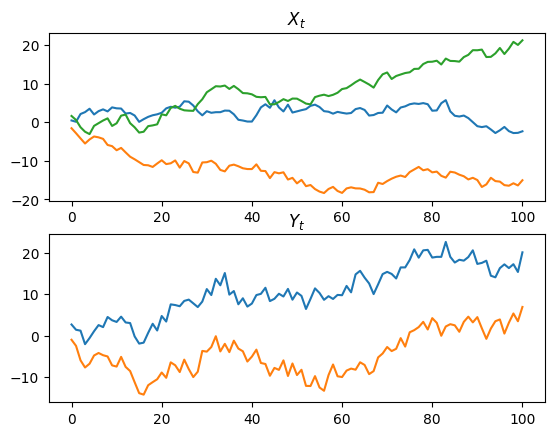

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("$X_t$")
ax1.plot(X)

ax2.set_title("$Y_t$")
ax2.plot(Y)
plt.show()

## Sampling from the smoothing distribution

After having run the Kalman filter we can use a recursion due to Frühwirth-Schnatter [@Fruhwirth-Schnatter1994Data] to obtain samples from the joint conditional distribution the states given observations.

By the dependency structure of states and observations the conditional densities can be factorized in the following way:

$$
\begin{align*}
p(x_0, \dots, x_n | y_0, \dots, y_n) &=  p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, \dots, x_n, y_0, \dots, y_n) \\
&= p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, y_0, \dots, y_n)
\end{align*}
$$

and the conditional distributions are again gaussian with conditional expecatation 
$$
\mathbf E (X_{t} | X_{t + 1}, Y_0, \dots, Y_n) = \hat X_{t|t} + G_t (X_{t + 1} - \hat X_{t + 1|t})
$$ and conditional covariance matrix 
$$
\text{Cov} (X_t | X_{t + 1}, Y_0, \dots, Y_n) = \Xi_{t|t} - G_t\Xi_{t + 1 | t} G_t^T
$$

where $G_t = \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1}$ is the smoothing gain.

In [ ]:
# | export
from isssm.kalman import kalman
def simulate_smoothed_FW1994(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"],
    N: int,
    key: jrn.KeyArray,
) -> Float[Array, "N n+1 m"]:
    r"""Simulate from smoothing distribution $p(X_0, \dots, X_n|Y_0, \dots, Y_n)$

    Parameters
    ----------
    x_filt :
        filtered states $\hat X_{t\vert t}$
    Xi_filt :
        filtered covariance matrices $\Xi_{t\vert t}$, $t=0,\dots,n$
    Xi_pred :
        prediction covariance matrices $\Xi_{t + 1 \vert t}$, $t=0, \dots, n-1$
    A :
        transition matrices $A_t$, $t=0,\dots,n-1$
    N :
        number of samples
    key :
        the random states

    Returns
    -------
    X :
        an array of N samples from the smoothing distribution
    """

    key, subkey = jrn.split(key)
    X_n = MVN(x_filt[-1], Xi_filt[-1]).sample(N, subkey)

    def sample_backwards(carry, inputs):
        X_smooth_next, key = carry
        x_filt, Xi_filt, Xi_pred, A = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A).T

        cond_expectation = x_filt + vmatmul(G, X_smooth_next - x_filt[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)
        return (new_samples, key), new_samples

    key, subkey = jrn.split(key)
    _, X = scan(
        sample_backwards,
        (X_n, subkey),
        (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A),
        reverse=True,
    )

    X_full = jnp.concatenate((X, X_n[None]))

    return X_full.transpose((1, 0, 2))


def FFBS(
    y: Float[Array, "n+1 m"],
    x0: Float[Array, "m"],
    Sigma: Float[Array, "n+1 m m"],
    Omega: Float[Array, "n+1 p p"],
    A: Float[Array, "n m m"],
    B: Float[Array, "n+1 p m"],
    N: int,
    key: jrn.KeyArray,
) -> Float[Array, "N n+1 m"]:
    r"""The Forward-Filter Backwards-Sampling Algorithm

    From [@Fruhwirth-Schnatter1994Data].

    Parameters
    ----------
    y :
        Observations $y$
    x0 :
        initial mean $\mathbf E X_0$
    Sigma :
        innovation covariances $\Sigma_t$
    Omega :
        errors $\Omega_t$
    A :
        transition matrices $A_t$
    B :
        observation matrices $B_t$
    N : int
        number of samples
    key : jrn.KeyArray
        random state

    Returns
    -------
    X :
        an array of N samples from the smoothing distribution
    """
    x_filt, Xi_filt, _, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)

    key, subkey = jrn.split(key)
    return simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, N, subkey)

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(Y, x0, Sigma, Omega, A, B)

key, subkey = jrn.split(key)
X_sim, = simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, 1, subkey)

assert X_sim.shape == (n + 1, m)

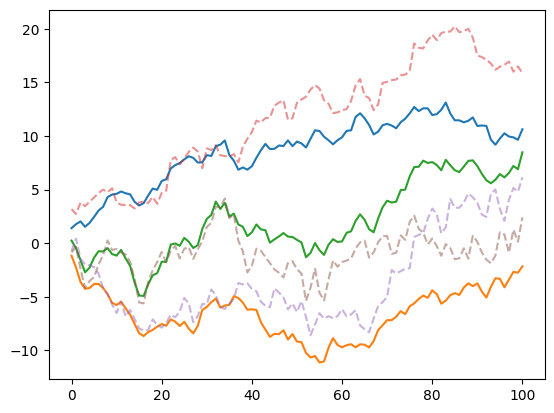

In [ ]:
x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)

plt.plot(x_smooth)
plt.plot(X_sim, alpha=.5, linestyle="dashed")
plt.show()

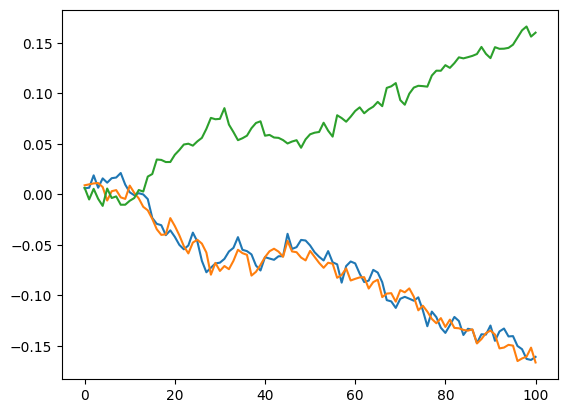

In [ ]:
#| hide
key, subkey = jrn.split(key)
X_sim = simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, 1e4, subkey)

plt.plot(X_sim.mean(axis = 0) - x_smooth)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()